In [2]:
from DataModules import MNISTSuperpixelDataModule
from utils.data import DenseData, DenseElement, densify_data
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch, Dataset, Data
from torch_geometric.datasets import MNISTSuperpixels
import matplotlib.pyplot as plt
import cv2
from torch_geometric.utils import dense_to_sparse
import numpy as np



MNIST_PATH = "../datasets/MNISTSuperpixel"
data_module = MNISTSuperpixelDataModule(MNIST_PATH, num_workers=6, filter_target=[0,1])
data_module.setup("fit")
loader = data_module.train_dataloader()
dense_data = next(iter(loader))

sparse_module = MNISTSuperpixels(MNIST_PATH)
sparse_loader = DataLoader(sparse_module, batch_size=32)
sparse_data = next(iter(sparse_loader))

print(dense_data)
print(sparse_data)

DenseElement(DenseData(x=(32, 75, 3), adj=(32, 75, 75), mask=(32, 75)), y=(32,))
DataBatch(x=[2400, 1], edge_index=[2, 44720], y=[32], pos=[2400, 2], batch=[2400], ptr=[33])


In [3]:
# def superpixels_to_image(rec: Data, scale: int = 30, edge_width: int = 1) -> np.ndarray:
#     pos = (rec.pos.clone() * scale).int()

#     image = np.zeros((scale * 26, scale * 26, 1), dtype=np.uint8)
#     for (color, (x, y)) in zip(rec.x, pos):
#         x0, y0 = int(x), int(y)
#         x1, y1 = x0 - scale, y0 - scale

#         color = int(float(color + 0.15) * 255)
#         color = min(color, 255)

#         cv2.rectangle(image, (x0, y0), (x1, y1), color, -1)

#     for node_ix_0, node_ix_1 in rec.edge_index.T:
#         x0, y0 = list(map(int, pos[node_ix_0]))
#         x1, y1 = list(map(int, pos[node_ix_1]))

#         x0 -= scale // 2
#         y0 -= scale // 2
#         x1 -= scale // 2
#         y1 -= scale // 2

#         cv2.line(image, (x0, y0), (x1, y1), 125, edge_width)
#     return image

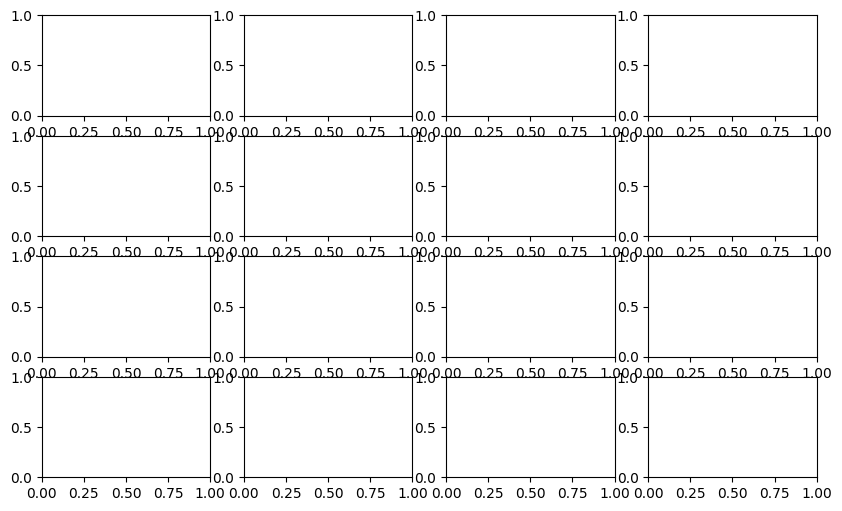

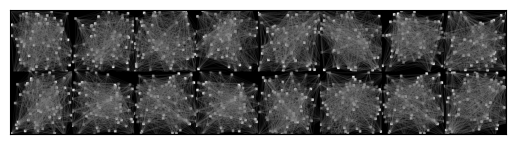

In [53]:
import random
from utils.graphs import generate_random_graph, superpixels_to_image
from torchvision.utils import make_grid
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

buffer: DenseData = densify_data(
        Batch.from_data_list(
            [generate_random_graph() for _ in range(32)]
        )
    )

sampled_indexes = random.choices(
    range(len(buffer)),
    k = 19
)

batch = buffer[sampled_indexes]

tot = (len(batch)// 4)
fig, axes = plt.subplots(4,tot, figsize=(10, 6))
axes = axes.flatten()
images = []
for i in range(len(batch[:( tot * 4)])):
    image = superpixels_to_image(batch[i])
    t = torch.from_numpy(image).permute(2, 1, 0)
    images.append(t)

grid = make_grid(images)
show(grid)


In [12]:
batch = dense_data.data[0]
edge_index = dense_to_sparse(batch.adj)[0]
edge_index

tensor([[ 0,  0,  0,  ..., 74, 74, 74],
        [ 2,  3,  4,  ..., 65, 66, 70]])

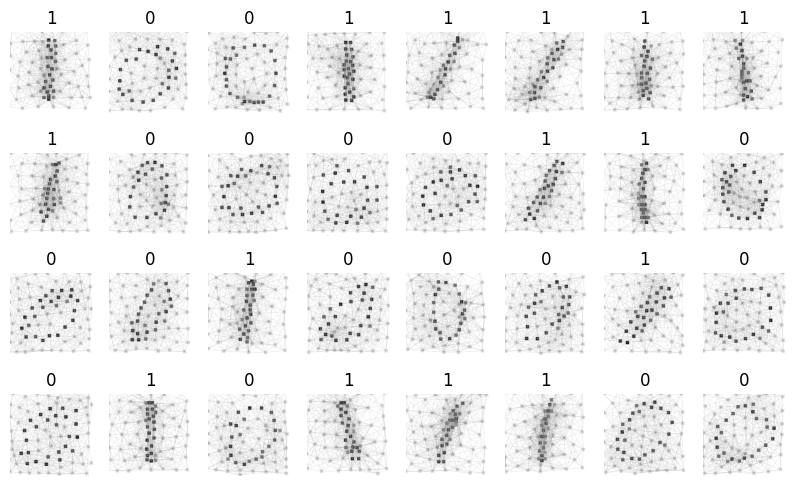

In [13]:
def superpixels_to_image(rec: DenseData, scale: int = 30, edge_width: int = 1) -> np.ndarray:
    pos = (rec.x[:,1:].clone() * scale).int()

    image = np.zeros((scale * 26, scale * 26, 1), dtype=np.uint8)
    for (color, (x, y)) in zip(rec.x[:,0], pos):
        x0, y0 = int(x), int(y)
        x1, y1 = x0 - scale, y0 - scale

        color = int(float(color + 0.15) * 255)
        color = min(color, 255)

        cv2.rectangle(image, (x0, y0), (x1, y1), color, -1)

    edge_index = dense_to_sparse(rec.adj)[0]
    for node_ix_0, node_ix_1 in edge_index.T:
        x0, y0 = list(map(int, pos[node_ix_0]))
        x1, y1 = list(map(int, pos[node_ix_1]))

        x0 -= scale // 2
        y0 -= scale // 2
        x1 -= scale // 2
        y1 -= scale // 2

        cv2.line(image, (x0, y0), (x1, y1), 125, edge_width)
    return image

batch = dense_data.data[:8]
y = dense_data.y[:8]

fig, axes = plt.subplots(4, len(batch)//4, figsize=(10, 6))
axes = axes.flatten()
for i in range(len(batch)):
    image = superpixels_to_image(batch[i])
    axes[i].imshow(image, cmap=plt.cm.binary)
    axes[i].axis("off")
    axes[i].set_title(f"{y[i]}")

In [14]:
from models.ebm import DeepEnergyModel
from utils import Sampler
from utils.graphs import generate_random_graph

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CHECKPOINT_PATH = "/home/mancio/git/ebm-molecules/graph_logs/lightning_logs/version_0/checkpoints/epoch=60-step=5490.ckpt"
# CHECKPOINT_PATH = "/home/mancio/git/ebm-molecules/graph_logs/lightning_logs/version_19/checkpoints/epoch=60-step=5490.ckpt"
CHECKPOINT_PATH = "/home/mancio/git/ebm-molecules/graph_logs/lightning_logs/version_23/checkpoints/epoch=100-step=17978.ckpt"

model = DeepEnergyModel.load_from_checkpoint(CHECKPOINT_PATH).to(device)
starting_graphs: DenseData = densify_data(
            Batch.from_data_list(
                [generate_random_graph(device=model.device) for _ in range(4)]
            )
        )
labels = torch.tensor([0,0,1,1])
result: DenseData = Sampler.generate_samples(model.cnn, starting_graphs, labels, 1024)

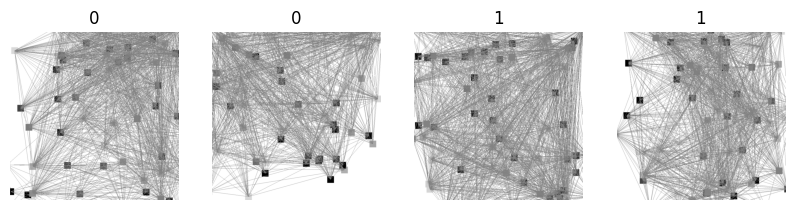

In [15]:
batch = result
y = labels

fig, axes = plt.subplots(1, len(batch), figsize=(10, 6))
axes = axes.flatten()
for i in range(len(batch)):
    image = superpixels_to_image(batch[i])
    axes[i].imshow(image, cmap=plt.cm.binary)
    axes[i].axis("off")
    axes[i].set_title(f"{y[i]}")